In [2]:
import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.join(os.path.abspath(''),'..','scripts'))
sys.path.append(os.path.join(os.path.abspath(''),'..','src'))

import osmium
from geopy.geocoders import Nominatim
import geopandas
from scipy.spatial import KDTree
import shapely
from shapely.geometry import Point, LineString
import pandas as pd
import pickle as pkl
import networkx as nx
import math
from tqdm import tqdm
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set(style="whitegrid", font_scale=1.8, rc={'axes.grid': True, 'figure.dpi': 120})

from helpers import *
DATA_PATH = '/Users/au624601/PhD/data/taxi/'

# Processing raw Chicago road map

- Extracting directed strongly connected component
- Loading Census boundaries
- Computing weights of edges according to the road map

In [2]:
# initial road network downloaded by scripts from WMA
G = nx.read_graphml(os.path.join(DATA_PATH, "chicago.graphml"))

In [4]:
# checking sizes of connected components
gg = [g for g in nx.weakly_connected_components(G)]
[len(g) for g in gg][:5]

[472720, 28, 3, 3, 1]

In [5]:
G = nx.DiGraph(G.subgraph(gg[0]))

In [6]:
# we need spatial index on nodes to get centers
points = []
kd_point_index = []
for n in G.nodes(data=True):
    kd_point_index.append(n[0])
    points.append([n[1]['lon'], n[1]['lat']])
points = np.array(points)
kdtree = KDTree(points)

In [7]:
census = geopandas.read_file(open(os.path.join(DATA_PATH, "Boundaries - Census Tracts - 2010.geojson"), "r").read()) 
census.tail()

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry
796,17,704,7,Census Tract 704,7,17031070400,,070400,031,"MULTIPOLYGON (((-87.65746 41.93258, -87.65722 ..."
797,17,705,7,Census Tract 705,7,17031070500,,070500,031,"MULTIPOLYGON (((-87.66349 41.93036, -87.66350 ..."
798,17,1303,13,Census Tract 1303,13,17031130300,,130300,031,"MULTIPOLYGON (((-87.71436 41.98300, -87.71472 ..."
799,17,2922,29,Census Tract 2922,29,17031292200,,292200,031,"MULTIPOLYGON (((-87.71317 41.85523, -87.71357 ..."
800,17,6309,63,Census Tract 6309,63,17031630900,,630900,031,"MULTIPOLYGON (((-87.71129 41.79340, -87.71090 ..."


In [8]:
# computing mean area
pd.to_numeric(census['commarea']).mean()

34.998751560549316

In [9]:
node_to_census = {}
census_to_nodes = {}
for i in census.index:
    census_to_nodes[i] = []

for n in tqdm(G.nodes(data=True)):
    found = False
    for i in census.index:
        if census.loc[i,'geometry'].contains(Point(n[1]['lon'],n[1]['lat'])):
            node_to_census[n[0]] = census.loc[i, "geoid10"]
            found = True
            break
print(len(census_to_nodes), len(node_to_census))
nx.set_node_attributes(G, node_to_census, "census")
nx.write_graphml(G, os.path.join(DATA_PATH, "chicago_processed.graphml"))
pkl.dump(census_to_nodes, open(os.path.join(DATA_PATH, "census_to_nodex.pkl"), "wb"))

100%|██████████| 472720/472720 [3:56:09<00:00, 33.36it/s]


801 240801


In [10]:
census_centroids = {}
for i in tqdm(census.index):
    census_centroids[census.loc[i,'name10']] = kd_point_index[kdtree.query(census.loc[i,'geometry'].centroid)[1]]
pkl.dump(census_centroids, open(os.path.join(DATA_PATH, "census_centroids.pkl"), "wb"))

100%|██████████| 801/801 [00:10<00:00, 76.12it/s] 


In [11]:
# assign weight in miles for each edges
def get_miles(lon0, lat0, lon, lat):
    dlat = lat - lat0;
    dlon = lon - lon0;
    latitudeCircumference = 40075160. * math.cos(lat0 * math.pi/180.0);
    resX = dlon * latitudeCircumference / 360. ;
    resY = dlat * 40008000. / 360. ;
    return math.sqrt(resX**2 + resY**2) * 0.000621371

for e in tqdm(G.edges()):
    miles = get_miles(G.nodes[e[0]]['lon'], G.nodes[e[0]]['lat'], G.nodes[e[1]]['lon'], G.nodes[e[1]]['lat'])
    G[e[0]][e[1]]['length'] = miles
    
# rewriting original graph with processed one
nx.write_graphml(G, os.path.join(DATA_PATH, "chicago_processed.graphml"))

100%|██████████| 591544/591544 [01:55<00:00, 5123.96it/s]


# Deriving graph

In [5]:
# load data
G = nx.read_graphml(os.path.join(DATA_PATH, "chicago_processed.graphml"))
# calculated by script in script folder
new_distances = pkl.load(open(os.path.join(DATA_PATH, "distances_new.pkl"), "rb"))

In [ ]:
census_centroids = pkl.load(open(os.path.join(DATA_PATH, "census_centroids.pkl"), "rb"))
census = geopandas.read_file(open(os.path.join(DATA_PATH, "Boundaries - Census Tracts - 2010.geojson"), "r").read()) 
centroids = geopandas.GeoDataFrame(census['name10'].apply(lambda x: Point(G.nodes[census_centroids[x]]['lon'], 
                                                                         G.nodes[census_centroids[x]]['lat'])))
centroids = centroids.rename(columns={"name10": "geometry"})

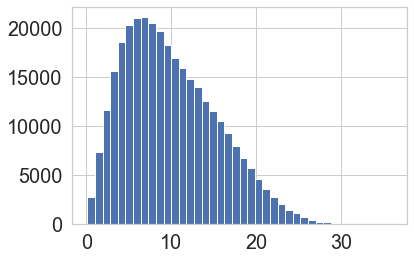

In [13]:
pd.Series([new_distances[k] for k in new_distances]).hist(bins=40)

In [14]:
pd.Series([new_distances[k] for k in new_distances]).describe()

count    320400.000000
mean          9.991951
std           5.514417
min           0.110953
25%           5.653573
50%           9.151911
75%          13.687110
max          35.987027
dtype: float64

In [123]:
# deriving graph by adding edges for close cells
census_geoids = set(census['geoid10'].unique())
census_to_id = {}
censusname10_to_id = {}
for idx, census_id in enumerate(census_geoids):
    census_to_id[census_id] = idx
    censusname10_to_id[census[census['geoid10'] == census_id].iloc[0]['name10']] = idx
edges = []
for k, val in new_distances.items():
    if val < 3.6:
        edges.append((censusname10_to_id[k[0]], censusname10_to_id[k[1]], val))

G = nx.Graph()
G.add_weighted_edges_from(edges)
id_to_census = {v: k for k, v in census_to_id.items()}

census_centroids = pkl.load(open(os.path.join(DATA_PATH, "census_centroids.pkl"), "rb"))
coords = {}
for i in range(len(G)):
    ind = census.index[census['geoid10'] == id_to_census[i]]
    p = census.loc[ind,'geometry'].centroid
    coords[i] = p.iloc[0].x, p.iloc[0].y

nx.set_node_attributes(G, id_to_census, name="census")
nx.set_node_attributes(G, coords, name="coords")
G = nx.convert_node_labels_to_integers(G)

In [ ]:
nx.write_gpickle(G, os.path.join(DATA_PATH, "chicago_g_new.pkl"))

# TRASH BEGINS

In [320]:
G = nx.read_gpickle(os.path.join(DATA_PATH, "chicago_g_new.pkl"))

In [322]:
nx.write_edgelist(G, os.path.join(DATA_PATH, "chicago_g_new.edges"),data=False)

In [323]:
degrees = [val for (node, val) in G.degree()]

In [325]:
max(degrees)

182

In [48]:
# this is because for some reason some nodes were missing coords so we add missing coords here
census_to_coords = {}
for i in range(len(id_to_census)):
    census_to_coords[id_to_census[i]] = coords[i]
    
for n in G.nodes(data=True):
    if 'coords' in n[1]:
        assert n[1]['coords'] == census_to_coords[n[1]['census']]
    else:
        G.nodes[n[0]]['coords'] = census_to_coords[n[1]['census']]

In [38]:
G.number_of_nodes(), G.number_of_edges(), nx.number_connected_components(G)

(799, 35573, 1)

In [50]:
nx.write_gpickle(G, os.path.join(DATA_PATH, "chicago_g_new.pkl"))

In [58]:
G = nx.read_gpickle(os.path.join(DATA_PATH, "chicago_g_new.pkl"))

In [20]:
a1 = set([n[1]['census'] for n in G.nodes(data=True)])
a2 = set(census['geoid10'])
[a for a in a2 if a not in a1]

['17031770602', '17031510100']

NameError: name 'centroids' is not defined

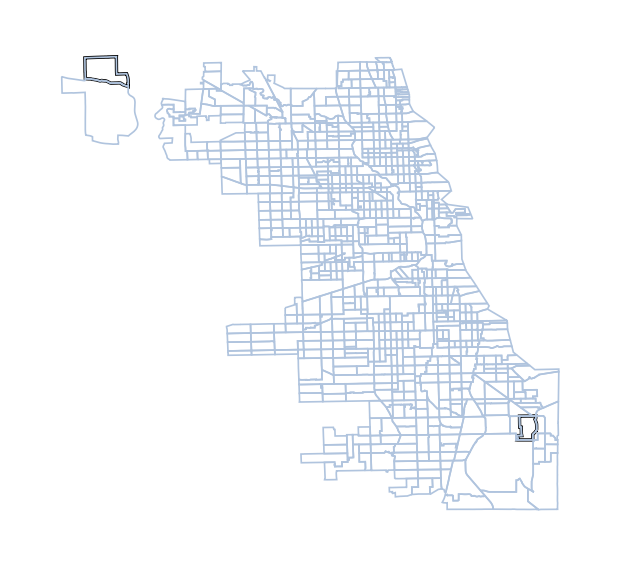

In [28]:
ax = gplt.polyplot(census[census['geoid10'] == '17031510100']['geometry'], linewidth=2)
gplt.polyplot(census[census['geoid10'] == '17031770602']['geometry'], linewidth=2, ax=ax)
gplt.polyplot(census['geometry'], edgecolor='lightsteelblue', ax=ax)
gplt.pointplot(centroids, ax=ax, s=1)

# MORE TRASH

In [142]:
df_filtered = pd.read_pickle(os.path.join(DATA_PATH, "Taxi_Trips_Filtered_2014_final.pkl"))
df_filtered.head()

,Unnamed: 0,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,avg_speed,fare_per_mile
13285001,57817659,bf144d3085b875983198aca2ccfa966dc544b7423ca28f...,2014-01-01,01/01/2014 12:15:00 AM,720.0,2.6,17031081700,17031071200,9.05,0.003611,3.480769
2015868,12647466,b75e4a5f5666b60eec9f1446230f23270002318dd86ff0...,2014-01-01,01/01/2014 12:15:00 AM,900.0,3.9,17031832600,17031060800,11.05,0.004333,2.833333
1328044,11838261,1d9f1ab92fd36a4578d77d25eecb75771962aa5047119a...,2014-01-01,01/01/2014 12:30:00 AM,1140.0,6.9,17031330100,17031062000,17.05,0.006053,2.471014
2103840,12745654,ef1e0a9fd7a9157b7cbb009b217401111cb3c560b0df61...,2014-01-01,01/01/2014 12:15:00 AM,1320.0,5.7,17031833100,17031832000,15.05,0.004318,2.640351
2784363,13455696,71f72bfa5361a2485e783a188a2e7479a00ed68a09842c...,2014-01-01,01/01/2014 12:15:00 AM,720.0,1.5,17031081500,17031081201,8.05,0.002083,5.366667


In [143]:
dd = df_filtered.groupby(['Trip Start Timestamp','Pickup Census Tract','Dropoff Census Tract'], as_index=False)['Fare'].count()
dd2 = dd.groupby(['Pickup Census Tract','Dropoff Census Tract'], as_index=False)['Fare'].sum()
dd2.head()

,Pickup Census Tract,Dropoff Census Tract,Fare
0,17031010100,17031020500,1
1,17031010100,17031980000,1
2,17031010201,17031010600,1
3,17031010201,17031020802,1
4,17031010201,17031031000,1


In [145]:
census = geopandas.read_file(open(os.path.join(DATA_PATH, "Boundaries - Census Tracts - 2010.geojson"), "r").read()) 

In [153]:
activity = pd.DataFrame(dd2.groupby('Pickup Census Tract')['Fare'].sum()).fillna(0)
for i in census['geoid10']:
    if i not in activity.index:
        activity.at[i, 'Fare'] = 0

census = census.astype(dtype={'geoid10': int})

In [154]:
census2 = census.join(activity, on='geoid10')

In [155]:
census3 = geopandas.GeoDataFrame(census2)

In [156]:
census3.crs = {'init' :'epsg:4326'}  
census3 = census3.to_crs({'init': 'epsg:4269'})

/Users/au624601/PhD/macao/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [243]:
census3

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry,Fare
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ...",2.0
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ...",476.0
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031,"MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ...",4483.0
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031,"MULTIPOLYGON (((-87.68813 41.85569, -87.68816 ...",6.0
4,17,8390,32,Census Tract 8390,32,17031839000,,839000,031,"MULTIPOLYGON (((-87.63312 41.87449, -87.63306 ...",49543.0
...,...,...,...,...,...,...,...,...,...,...,...
796,17,704,7,Census Tract 704,7,17031070400,,070400,031,"MULTIPOLYGON (((-87.65746 41.93258, -87.65722 ...",25745.0
797,17,705,7,Census Tract 705,7,17031070500,,070500,031,"MULTIPOLYGON (((-87.66349 41.93036, -87.66350 ...",8170.0
798,17,1303,13,Census Tract 1303,13,17031130300,,130300,031,"MULTIPOLYGON (((-87.71436 41.98300, -87.71472 ...",10.0
799,17,2922,29,Census Tract 2922,29,17031292200,,292200,031,"MULTIPOLYGON (((-87.71317 41.85523, -87.71357 ...",0.0


In [249]:
# this is to illustrate the "fake" order distribution
mapped_orders = pd.read_csv(os.path.join(DATA_PATH, "mapped_orders.csv"),header=None)
mapped_orders[5] = mapped_orders[2].apply(lambda x: int(x % (60*24/15)))
aa = pd.DataFrame(mapped_orders.groupby([0],as_index=False).count())
aa

,0,1,2,3,4,5
0,4,1,1,1,1,1
1,7,1100,1100,1100,1100,1100
2,10,1,1,1,1,1
3,12,1,1,1,1,1
4,15,248660,248660,248660,248660,248660
...,...,...,...,...,...,...
408,788,202484,202484,202484,202484,202484
409,789,1,1,1,1,1
410,790,4,4,4,4,4
411,794,22968,22968,22968,22968,22968


In [312]:
mm = []
un = aa[0].unique()
for n in G.nodes(data=True):
    mm.append((n[1]['census'], aa[aa[0]==n[0]].iloc[0][1] if n[0] in un else 0))

In [313]:
mm1 = pd.DataFrame(mm).rename(columns={0:'geoid10', 1:"Fare"})
mm1['geoid10'] = pd.to_numeric(mm1['geoid10'])
mm1['Fare'] = pd.to_numeric(mm1['Fare'])
mm1 = mm1.set_index('geoid10')
mm1

,Fare
geoid10,
17031842400,0
17031440201,0
17031834900,0
17031842500,0
17031834300,1
...,...
17031823304,22968
17031740300,488
17031520500,0


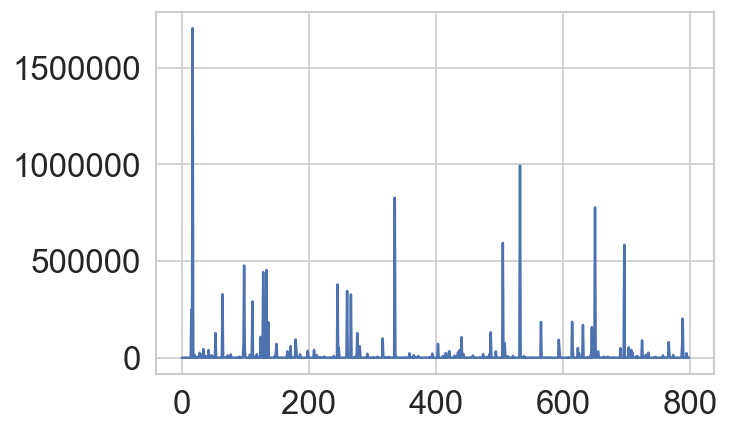

In [314]:
plt.plot(list(mm1['Fare']))

In [315]:
census = census.astype(dtype={'geoid10': int})
census2 = census.join(mm1, on='geoid10', lsuffix='1', rsuffix='2', how='inner')
census3 = geopandas.GeoDataFrame(census2)
census3.crs = {'init' :'epsg:4326'}  
census3 = census3.to_crs({'init': 'epsg:4269'})

/Users/au624601/PhD/macao/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [316]:
census3

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry,Fare
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ...",0
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ...",11892
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031,"MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ...",0
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031,"MULTIPOLYGON (((-87.68813 41.85569, -87.68816 ...",55
4,17,8390,32,Census Tract 8390,32,17031839000,,839000,031,"MULTIPOLYGON (((-87.63312 41.87449, -87.63306 ...",8441
...,...,...,...,...,...,...,...,...,...,...,...
796,17,704,7,Census Tract 704,7,17031070400,,070400,031,"MULTIPOLYGON (((-87.65746 41.93258, -87.65722 ...",614
797,17,705,7,Census Tract 705,7,17031070500,,070500,031,"MULTIPOLYGON (((-87.66349 41.93036, -87.66350 ...",519
798,17,1303,13,Census Tract 1303,13,17031130300,,130300,031,"MULTIPOLYGON (((-87.71436 41.98300, -87.71472 ...",0
799,17,2922,29,Census Tract 2922,29,17031292200,,292200,031,"MULTIPOLYGON (((-87.71317 41.85523, -87.71357 ...",8994


In [317]:
census3[census3["Fare"].isna()]

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry,Fare


In [318]:
scheme = mc.FisherJenks(census3['Fare'], k=30)

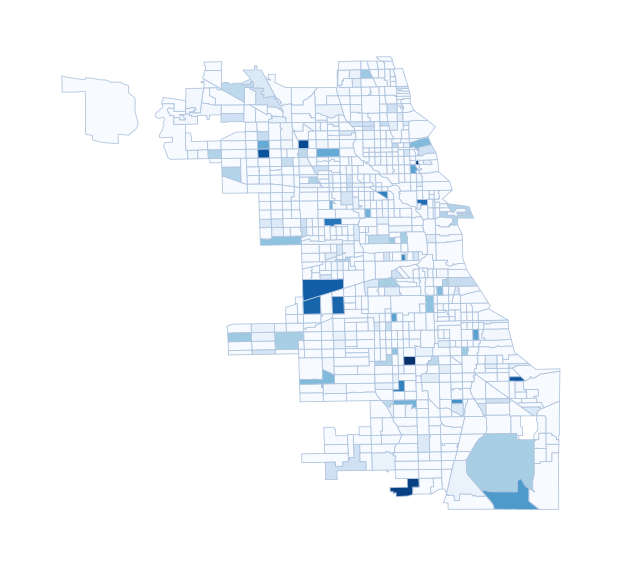

In [319]:
ax = gplt.choropleth(
    census3, hue='Fare',
    edgecolor='lightsteelblue', linewidth=0.5,
    cmap='Blues',
    scheme=scheme
)

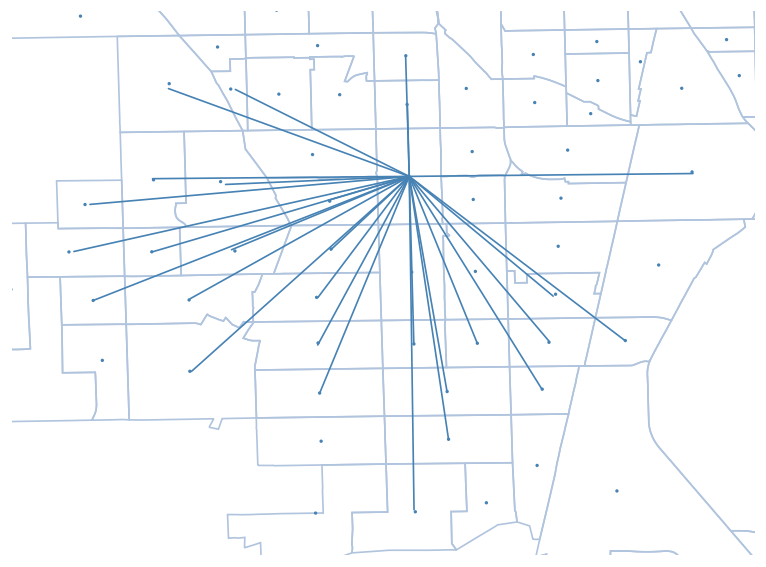

In [162]:
# load data
road_G = nx.read_graphml(os.path.join(DATA_PATH, "chicago_processed.graphml"))

census_centroids = pkl.load(open(os.path.join(DATA_PATH, "census_centroids.pkl"), "rb"))
census = geopandas.read_file(open(os.path.join(DATA_PATH, "Boundaries - Census Tracts - 2010.geojson"), "r").read()) 
centroids = geopandas.GeoDataFrame(census['name10'].apply(lambda x: Point(road_G.nodes[census_centroids[x]]['lon'], 
                                                                         road_G.nodes[census_centroids[x]]['lat'])))
centroids = centroids.rename(columns={"name10": "geometry"})

t = []
for e in G.edges():
    if e[0] == 66:
        n1 = G.nodes[e[0]]
        n2 = G.nodes[e[1]]
        ls = LineString([(n1['coords'][0], n1['coords'][1]), (n2['coords'][0], n2['coords'][1])])
        t.append(ls)

edges_to_plot = geopandas.GeoDataFrame({'geometry': t})
len(edges_to_plot)

ax = gplt.polyplot(census['geometry'], edgecolor='lightsteelblue')
gplt.pointplot(centroids, ax=ax, s=1)
gplt.sankey(edges_to_plot['geometry'], ax=ax)

# Compute Space Division

In [59]:
space_division = {}

min_x = 100000
max_x = -100000
min_y = 100000
max_y = -100000
for n in G.nodes(data=True):
    x = n[1]['coords'][0]
    y = n[1]['coords'][1]
    min_x = min(min_x, x)
    max_x = max(max_x, x)
    min_y = min(min_y, y)
    max_y = max(max_y, y)

In [74]:
x_div = 3
y_div = 4
delta_x = (max_x-min_x)/x_div
delta_y = (max_y-min_y)/y_div
for n in G.nodes(data=True):
    x = n[1]['coords'][0]
    y = n[1]['coords'][1]
    ind_x = (x - min_x) // delta_x
    ind_y = (y - min_y) // delta_y
    ind = ind_x + ind_y*3
    space_division[n[0]] = ind

In [75]:
nx.set_node_attributes(G, space_division, name="space_division")

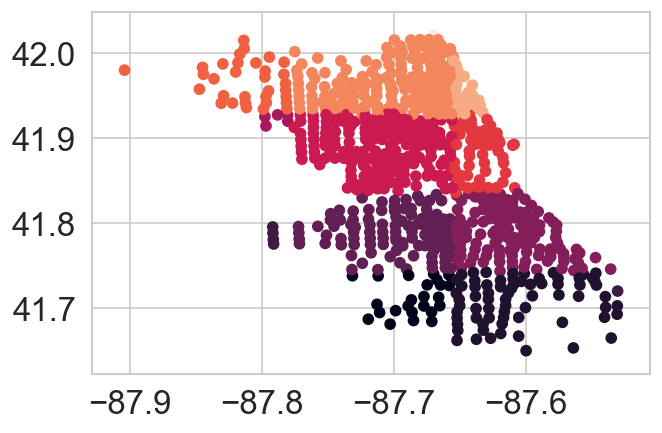

In [76]:
temp = [(n[1]['coords'][0], n[1]['coords'][1],n[1]['space_division']) for n in G.nodes(data=True)]
temp = np.array(temp)
plt.scatter(temp[:,0], temp[:,1],c=temp[:,2]/np.max(temp[:,2]))

In [109]:
pd.Series([G.degree(n) for n in G.nodes()]).describe()

count    799.000000
mean      89.043805
std       38.359719
min        1.000000
25%       62.000000
50%       89.000000
75%      114.500000
max      182.000000
dtype: float64

# Some Abandoned code

In [ ]:
# this is outdated, modified and abandoned because its much easier (especiaaly in regards of disconnected airport) to
# calculate distances based on eucledian distances between centorids and average car speed
# plus there is a problem with road network: it does not really look like census tracts, too much redundant, 
# and its not connected for unknown reason

# but then how to calculate nearest cell? simply based on census graph!

census_centroids = pkl.load(open(os.path.join(DATA_PATH, "census_centroids.pkl"), "rb"))
distances = {}
for k1 in tqdm(census_centroids):  #indexed by name10
    spath = nx.single_source_dijkstra_path(G, census_centroids[k1], weight="length")
    for k2 in census_centroids:
        if k1 == k2 or (k1,k2) in distances:
            continue
        if census_centroids[k2] in sd:
            if census_centroids[k2] not in spath:
                p_length = -1
            else:
                p_path = spath[census_centroids[k2]]
                p_length = np.sum([G.edges[p_path[i], p_path[i+1]]['length'] for i in range(len(p_path)-1)])
            distances[(k1, k2)] = p_length
            distances[(k2, k1)] = p_length
pkl.dump(distances, open(os.path.join(DATA_PATH, "distances_new.pkl"), "wb"))

In [ ]:
# this is way too slow
def astar_heuristic(n1, n2):
    return (G.nodes[n1]['lon'] - G.nodes[n2]['lon'])**2 + (G.nodes[n1]['lat'] - G.nodes[n2]['lat'])**2

census_centroids = pkl.load(open(os.path.join(DATA_PATH, "census_centroids.pkl"), "rb"))
distances = {}
for k1 in census_centroids:
    for k2 in tqdm(census_centroids):
        if k1 == k2 or (k1,k2) in distances:
            continue
        p_length = nx.astar_path_length(G, census_centroids[k1], census_centroids[k2], heuristic=astar_heuristic, weight='length')
        distances[(k1, k2)] = p_length
        distances[(k2, k1)] = p_length

pkl.dump(distances, open(os.path.join(DATA_PATH, "distances.pkl"), "wb"))

# Computing df_filtered

In [ ]:
import time

limit = 1000000
offset = 1
cols = ['Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds',
        'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract', 'Fare']
df_filtered = pd.DataFrame()

with open(os.path.join(DATA_PATH, "Taxi_Trips.csv"),'r') as f:
    header = f.readline().split(',')
    while True:
        df = pd.read_csv(f, nrows=limit, header=None, names=header, usecols=cols, dtype=str)
        if len(df) == 0:
            break
        print(time.strftime("%Y-%m-%d %H:%M"), ":", offset/limit)
        df = df[df['Pickup Census Tract'].notna()][df['Dropoff Census Tract'].notna()][df['Trip Seconds'] != "0"][df['Taxi ID'].notna()]
        df = df[cols]
        df_filtered = pd.concat([df_filtered, df])
        offset += limit
df_filtered = df_filtered.reset_index()
df_filtered = df_filtered[cols]
df_filtered.to_csv(os.path.join(DATA_PATH, "Taxi_Trips_Filtered.csv"))
# 50min, can be faster by direct write to a file

In [25]:
with open(os.path.join(DATA_PATH, "Taxi_Trips_Filtered.csv"), "r") as f:
    with open(os.path.join(DATA_PATH, "Taxi_Trips_Filtered_2014.csv"), "w") as f_out:
        head = f.readline()
        f_out.write(head)
        for l in f:
            if l.find("2014") > -1:
                f_out.write(l)

# Trips analysis and additional cleaning of year trips

In [21]:
df_filtered = pd.read_csv(os.path.join(DATA_PATH, "Taxi_Trips_Filtered_2014.csv"))
len(df_filtered)

19674261

In [28]:
df_filtered['Trip Start Timestamp'] = pd.to_datetime(df_filtered['Trip Start Timestamp'], errors='coerce')

In [29]:
df_filtered = df_filtered[df_filtered['Trip Start Timestamp'].apply(lambda x: x.year) == 2014]

In [31]:
df_filtered.to_pickle(os.path.join(DATA_PATH, "Taxi_Trips_Filtered_2014.pkl"))

In [145]:
df_filtered = pd.read_pickle(os.path.join(DATA_PATH, "Taxi_Trips_Filtered_2014.pkl"))

In [36]:
w.max(), w.min()

(4493, 47)

In [146]:
df_filtered = df_filtered[df_filtered['Fare'] < 50][df_filtered['Fare'] > 0]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [147]:
df_filtered = df_filtered[df_filtered['Trip Miles'] < 25][df_filtered['Trip Miles'] > 0]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [148]:
df_filtered['avg_speed'] = df_filtered['Trip Miles']/df_filtered['Trip Seconds']

In [149]:
df_filtered['fare_per_mile'] = df_filtered['Fare']/df_filtered['Trip Miles']

In [141]:
# df_filtered = df_filtered[df_filtered['fare_per_mile']< 200]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


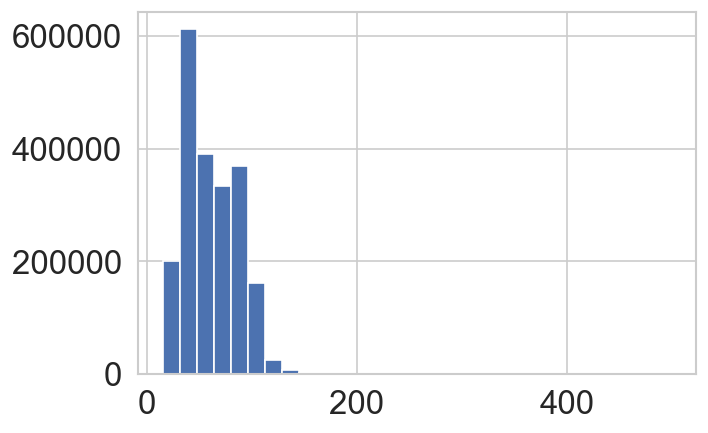

In [158]:
df_filtered[df_filtered['fare_per_mile']>16][df_filtered['fare_per_mile']<500]['fare_per_mile'].hist(bins=30)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


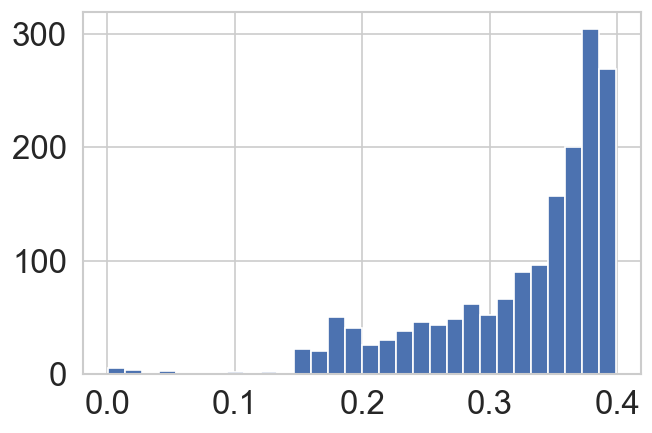

In [162]:
df_filtered[df_filtered['fare_per_mile']<0.4]['fare_per_mile'].hist(bins=30)

In [160]:
# number of trips to airport
len(df_filtered[df_filtered['fare_per_mile']>16])/len(df_filtered)

0.13747916940824834

In [165]:
len(df_filtered[df_filtered['fare_per_mile']<0.5])/len(df_filtered)

0.00027491820857562403

In [133]:
df_filtered_sample = df_filtered.sample(100000)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


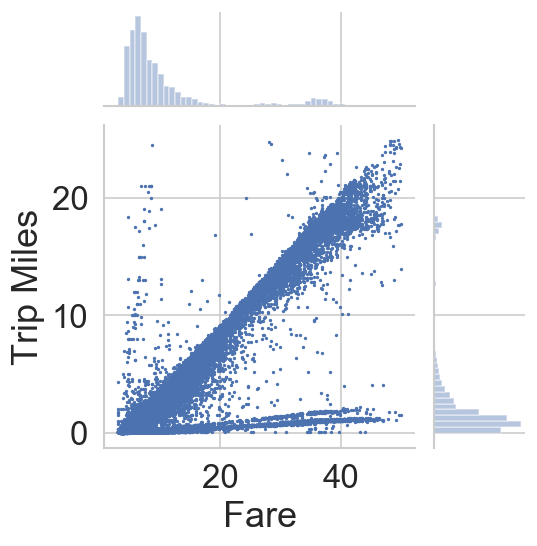

In [98]:
sns.set(style="whitegrid", font_scale=1.8, rc={'axes.grid': True, 'figure.dpi': 120})
plot = sns.jointplot(x='Fare', y='Trip Miles', data=df_filtered_sample, height=5, ratio=3, s=1)

In [ ]:
df_filtered_sample

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


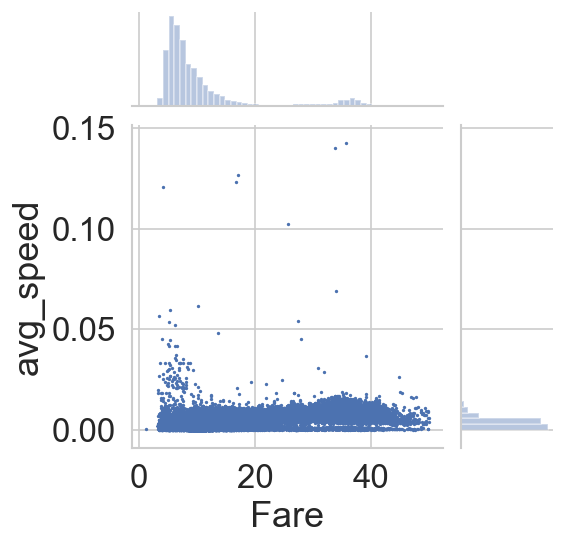

In [134]:
plot = sns.jointplot(x='Fare', y='avg_speed', data=df_filtered_sample, height=5, ratio=3, s=1)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


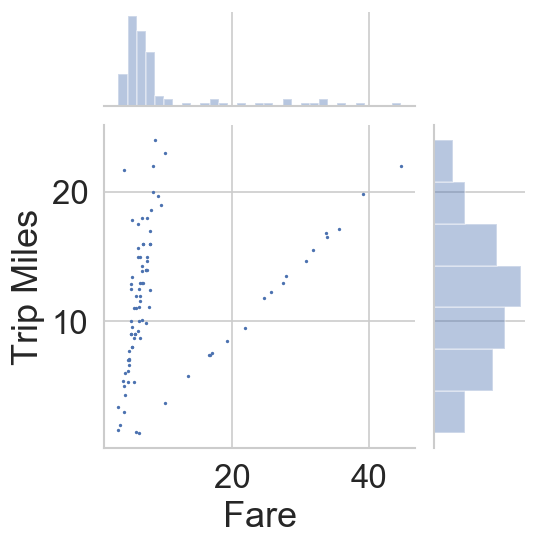

In [135]:
sns.jointplot(x='Fare', y='Trip Miles', data=df_filtered_sample[df_filtered_sample['avg_speed'] > 0.02], height=5, ratio=3, s=1)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


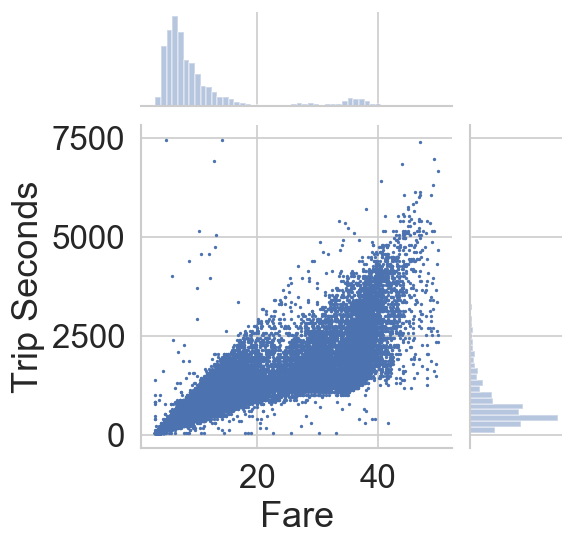

In [115]:
plot = sns.jointplot(x='Fare', y='Trip Seconds', data=df_filtered_sample[df_filtered_sample['Trip Seconds'] < 7500], height=5, ratio=3, s=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


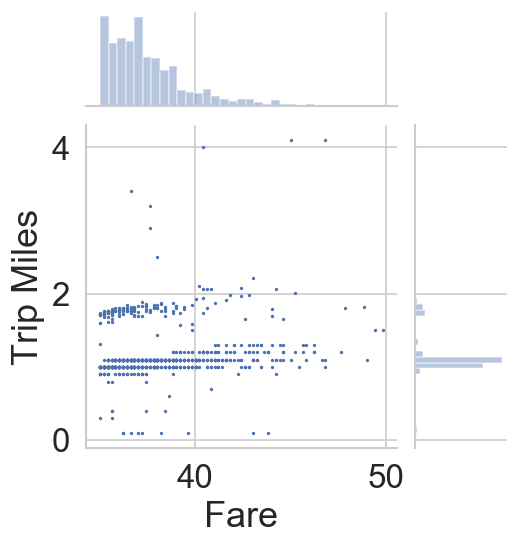

In [125]:
sns.jointplot(x='Fare', y='Trip Miles', data=df_filtered_sample[df_filtered_sample['Fare']>35][df_filtered_sample['Trip Miles']<5], height=5, ratio=3, s=1)

In [177]:
df_filtered = df_filtered[df_filtered['fare_per_mile']>=0.5][df_filtered['fare_per_mile']<=16]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [179]:
df_filtered.to_pickle(os.path.join(DATA_PATH, "Taxi_Trips_Filtered_2014_final.pkl"))

# Some filtering of year trip done once

In [2]:
df_filtered = pd.read_pickle(os.path.join(DATA_PATH, "Taxi_Trips_Filtered_2014_final.pkl"))
df_filtered.head()

,Unnamed: 0,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,avg_speed,fare_per_mile
13285001,57817659,bf144d3085b875983198aca2ccfa966dc544b7423ca28f...,2014-01-01,01/01/2014 12:15:00 AM,720.0,2.6,17031081700,17031071200,9.05,0.003611,3.480769
2015868,12647466,b75e4a5f5666b60eec9f1446230f23270002318dd86ff0...,2014-01-01,01/01/2014 12:15:00 AM,900.0,3.9,17031832600,17031060800,11.05,0.004333,2.833333
1328044,11838261,1d9f1ab92fd36a4578d77d25eecb75771962aa5047119a...,2014-01-01,01/01/2014 12:30:00 AM,1140.0,6.9,17031330100,17031062000,17.05,0.006053,2.471014
2103840,12745654,ef1e0a9fd7a9157b7cbb009b217401111cb3c560b0df61...,2014-01-01,01/01/2014 12:15:00 AM,1320.0,5.7,17031833100,17031832000,15.05,0.004318,2.640351
2784363,13455696,71f72bfa5361a2485e783a188a2e7479a00ed68a09842c...,2014-01-01,01/01/2014 12:15:00 AM,720.0,1.5,17031081500,17031081201,8.05,0.002083,5.366667


In [55]:
print(len(df_filtered)) # filtering those which do not have proper roads to the centroid (first two), and third is not inside chicago census tracts
df_filtered = df_filtered[~df_filtered['Pickup Census Tract'].isin(['17031770602', '17031510100', '17031770700'])]
df_filtered = df_filtered[~df_filtered['Dropoff Census Tract'].isin(['17031770602', '17031510100', '17031770700'])]
print(len(df_filtered))

13234866
13196423


In [136]:
all_census = set([n[1]['census'] for n in G.nodes(data=True)])

In [137]:
print(len(df_filtered))
df_filtered = df_filtered[df_filtered['Pickup Census Tract'].isin(all_census)]
df_filtered = df_filtered[df_filtered['Dropoff Census Tract'].isin(all_census)]
print(len(df_filtered))

13196423
13179391


In [138]:
df_filtered.to_pickle(os.path.join(DATA_PATH, "Taxi_Trips_Filtered_2014_final.pkl"))

# Some more shit

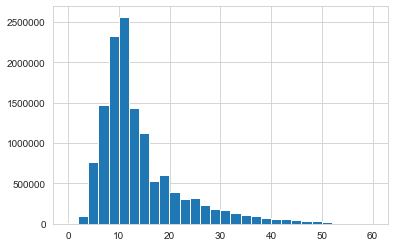

In [35]:
aa = (df_filtered['avg_speed']*3600)
aa[aa < 60].hist(bins=30)

In [36]:
aa[aa < 60].describe()

count    1.321915e+07
mean     1.428661e+01
std      8.298948e+00
min      1.364785e-02
25%      9.000000e+00
50%      1.200000e+01
75%      1.650000e+01
max      5.996471e+01
Name: avg_speed, dtype: float64

In [45]:
14.3/4

3.575

In [24]:
len(df_filtered)

13235492

Text(0, 0.5, 'Number of Drivers')

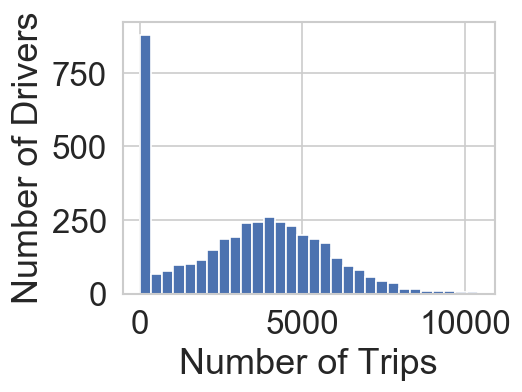

In [200]:
fig = plt.figure(figsize=(4,3), dpi=120)
ax = fig.add_subplot(1, 1, 1)
df_filtered.groupby('Taxi ID')['Fare'].count().hist(bins=30,ax=ax)
plt.xlabel("Number of Trips")
plt.ylabel("Number of Drivers")

In [216]:
df_filtered.groupby('Taxi ID')['Fare'].count().mean()

3210.9393498301797

In [202]:
v = df_filtered.groupby('Taxi ID')['Fare'].count()

In [213]:
len(v)

4122

In [212]:
len(v[v < 50])

801

In [215]:
len(v[v >= 50])

3321

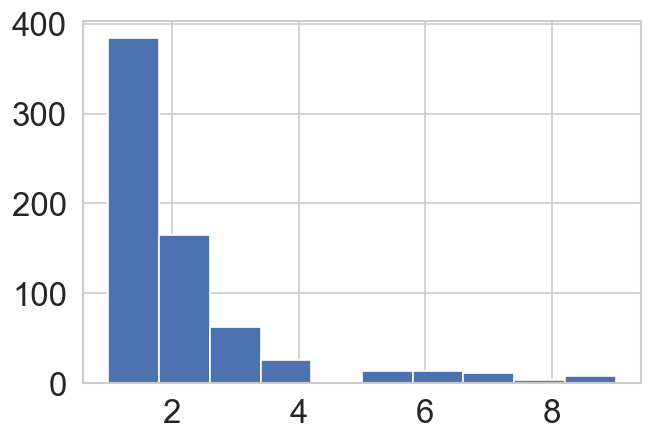

In [194]:
v = v[v < 10]
v.hist()

In [217]:
dd = df_filtered.groupby('Taxi ID')['Fare'].sum()

Text(0, 0.5, 'Number of Drivers')

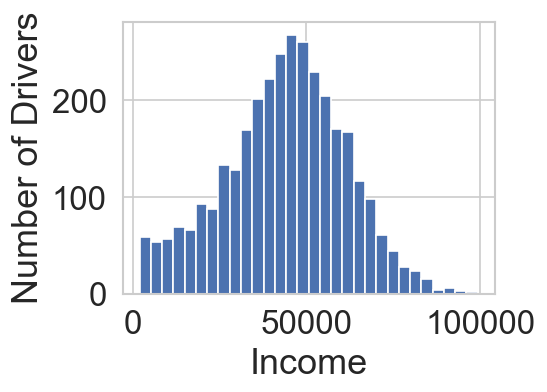

In [236]:
fig = plt.figure(figsize=(4,3), dpi=120)
ax = fig.add_subplot(1, 1, 1)
dd = dd[dd > 2000]
dd.hist(bins=30, ax=ax)
plt.xlabel("Income")
plt.ylabel("Number of Drivers")

In [90]:
df_filtered['week'] = df_filtered['Trip Start Timestamp'].apply(lambda x: x.week)

In [182]:
w = df_filtered.groupby('week')['Taxi ID'].nunique()

In [237]:
# learn probability functions
df_filtered['Trip Start Timestamp'].unique()

array(['2014-04-07T21:30:00.000000000', '2014-04-11T19:30:00.000000000',
       '2014-04-11T19:00:00.000000000', ...,
       '2014-12-23T04:00:00.000000000', '2014-12-09T03:15:00.000000000',
       '2014-10-28T04:00:00.000000000'], dtype='datetime64[ns]')

In [241]:
from datetime import timedelta, datetime

In [244]:
start_date = datetime(2014,1,1)
time_delta = timedelta(minutes=15)

for n in range(10):
    print(start_date.strftime("%Y-%m-%d: %H : %M"))
    start_date += time_delta



2014-01-01: 00 : 00
2014-01-01: 00 : 15
2014-01-01: 00 : 30
2014-01-01: 00 : 45
2014-01-01: 01 : 00
2014-01-01: 01 : 15
2014-01-01: 01 : 30
2014-01-01: 01 : 45
2014-01-01: 02 : 00
2014-01-01: 02 : 15


In [249]:
df_filtered['Trip Seconds'].mean()/60

12.679816405859198

# Getting top hubs for 2Hub

In [3]:
# group by time interval, count source and destination
dd = df_filtered.groupby(['Trip Start Timestamp','Pickup Census Tract','Dropoff Census Tract'], as_index=False)['Fare'].count()
dd2 = dd.groupby(['Pickup Census Tract','Dropoff Census Tract'], as_index=False)['Fare'].sum()

In [5]:
len(dd2)  # this contains a sum of trips per each non-zero pair of census tracts

52289

In [61]:
len(dd2['Fare'].value_counts())

2297

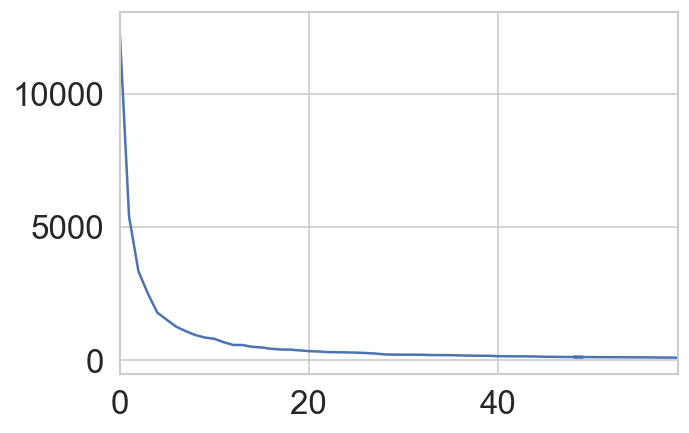

In [62]:
pd.Series(list(dd2['Fare'].value_counts())).sort_values()[::-1][:60].plot()
# plot frequency per pair of census tracts

In [63]:
dd2['Fare'].sort_values()[::-1][:1000].sum()/dd2['Fare'].sum()

0.7269370646879082

In [64]:
801*801

641601

In [65]:
len(dd2[dd2['Fare'] > 10])

23770

In [66]:
len(dd2[dd2['Fare'] > 0])

54954

In [67]:
55308 / 641601

0.08620310753879748

Text(0.5, 0, 'ID of Src / Dest Pair')

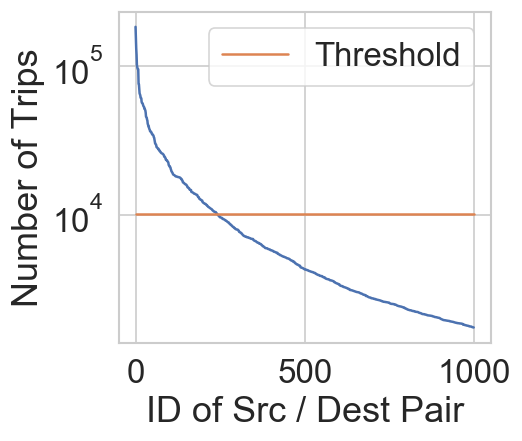

In [73]:
fig = plt.figure(figsize=(4,3.65), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.plot(list(dd2.sort_values('Fare')[::-1][:1000]['Fare']))
plt.plot([list(dd2.sort_values('Fare')[::-1][:1000]['Fare'])[240]]*1000, label="Threshold")
plt.legend()
plt.yscale('log')
plt.ylabel("Number of Trips")
plt.xlabel("ID of Src / Dest Pair")

In [74]:
top_hubs = dd2.sort_values('Fare')[::-1][:240]

In [75]:
top_hubs_set = set(top_hubs['Pickup Census Tract'].unique()).union(set(top_hubs['Dropoff Census Tract'].unique()))
len(top_hubs_set)

31

In [77]:
pkl.dump(top_hubs_set, open(os.path.join(DATA_PATH, "31-top-hubs.pkl"),'wb'))

In [20]:
dd2['from_top'] = dd2['Pickup Census Tract'].apply(lambda x: x in top_hubs_set)
dd2['to_top'] = dd2['Dropoff Census Tract'].apply(lambda x: x in top_hubs_set)
print("neigh->top: {}; top->neigh: {}; top->top: {}. neigh->neigh: {}".format(len(dd2[~dd2['from_top']][dd2['to_top']]),
                                                            len(dd2[dd2['from_top']][~dd2['to_top']]),
                                                            len(dd2[dd2['from_top']][dd2['to_top']]),
                                                            len(dd2[~dd2['from_top']][~dd2['to_top']])))

neigh->top: 6846; top->neigh: 9694; top->top: 835. neigh->neigh: 37933


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [21]:
print("neigh->top: {}; top->neigh: {}; top->top: {}. neigh->neigh: {}".format(dd2[~dd2['from_top']][dd2['to_top']]['Fare'].sum()/dd2['Fare'].sum(),
                                                            dd2[dd2['from_top']][~dd2['to_top']]['Fare'].sum()/dd2['Fare'].sum(),
                                                            dd2[dd2['from_top']][dd2['to_top']]['Fare'].sum()/dd2['Fare'].sum(),
                                                            dd2[~dd2['from_top']][~dd2['to_top']]['Fare'].sum()/dd2['Fare'].sum()))

neigh->top: 0.09746241393973114; top->neigh: 0.15399321763029286; top->top: 0.6448534742796113. neigh->neigh: 0.1036908941503648


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [69]:
dd2['from_top'] = dd2['Pickup Census Tract'].apply(lambda x: x in top_hubs_set)
dd2['to_top'] = dd2['Dropoff Census Tract'].apply(lambda x: x in top_hubs_set)

In [78]:
print("neigh->top: {}; top->neigh: {}; top->top: {}. neigh->neigh: {}".format(len(dd2[~dd2['from_top']][dd2['to_top']]),
                                                            len(dd2[dd2['from_top']][~dd2['to_top']]),
                                                            len(dd2[dd2['from_top']][dd2['to_top']]),
                                                            len(dd2[~dd2['from_top']][~dd2['to_top']])))

neigh->top: 12477; top->neigh: 17936; top->top: 6553. neigh->neigh: 18342


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [81]:
sum([len(dd2[~dd2['from_top']][dd2['to_top']]),len(dd2[dd2['from_top']][~dd2['to_top']]),len(dd2[dd2['from_top']][dd2['to_top']]),len(dd2[~dd2['from_top']][~dd2['to_top']])])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


55308

In [88]:
print("neigh->top: {}; top->neigh: {}; top->top: {}. neigh->neigh: {}".format(dd2[~dd2['from_top']][dd2['to_top']]['Fare'].sum()/dd2['Fare'].sum(),
                                                            dd2[dd2['from_top']][~dd2['to_top']]['Fare'].sum()/dd2['Fare'].sum(),
                                                            dd2[dd2['from_top']][dd2['to_top']]['Fare'].sum()/dd2['Fare'].sum(),
                                                            dd2[~dd2['from_top']][~dd2['to_top']]['Fare'].sum()/dd2['Fare'].sum()))

neigh->top: 0.03278268764017235; top->neigh: 0.06302818210309069; top->top: 0.8878940805525023. neigh->neigh: 0.016295049704234645


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


# Preparing for experiments

- creating a graph with census tracts
- mapping census tracts to node_ids
- exporting full and sampled taxi trips
- exporting number of available drivers

In [167]:
df_filtered = pd.read_pickle(os.path.join(DATA_PATH, "Taxi_Trips_Filtered_2014_final.pkl"))
df_filtered.head()

,Unnamed: 0,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,avg_speed,fare_per_mile
13285001,57817659,bf144d3085b875983198aca2ccfa966dc544b7423ca28f...,2014-01-01,01/01/2014 12:15:00 AM,720.0,2.6,17031081700,17031071200,9.05,0.003611,3.480769
2015868,12647466,b75e4a5f5666b60eec9f1446230f23270002318dd86ff0...,2014-01-01,01/01/2014 12:15:00 AM,900.0,3.9,17031832600,17031060800,11.05,0.004333,2.833333
1328044,11838261,1d9f1ab92fd36a4578d77d25eecb75771962aa5047119a...,2014-01-01,01/01/2014 12:30:00 AM,1140.0,6.9,17031330100,17031062000,17.05,0.006053,2.471014
2103840,12745654,ef1e0a9fd7a9157b7cbb009b217401111cb3c560b0df61...,2014-01-01,01/01/2014 12:15:00 AM,1320.0,5.7,17031833100,17031832000,15.05,0.004318,2.640351
2784363,13455696,71f72bfa5361a2485e783a188a2e7479a00ed68a09842c...,2014-01-01,01/01/2014 12:15:00 AM,720.0,1.5,17031081500,17031081201,8.05,0.002083,5.366667


In [168]:
notimeind = df_filtered['Trip Seconds'].notna()
df_filtered = df_filtered[notimeind]

In [169]:
df_filtered.dtypes

Unnamed: 0                       int64
Taxi ID                         object
Trip Start Timestamp    datetime64[ns]
Trip End Timestamp              object
Trip Seconds                   float64
Trip Miles                     float64
Pickup Census Tract              int64
Dropoff Census Tract             int64
Fare                           float64
avg_speed                      float64
fare_per_mile                  float64
dtype: object

In [170]:
# check if census are neighbors
census = geopandas.read_file(open(os.path.join(DATA_PATH, "Boundaries - Census Tracts - 2010.geojson"), "r").read()) 
census.tail()

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry
796,17,704,7,Census Tract 704,7,17031070400,,070400,031,"MULTIPOLYGON (((-87.65746 41.93258, -87.65722 ..."
797,17,705,7,Census Tract 705,7,17031070500,,070500,031,"MULTIPOLYGON (((-87.66349 41.93036, -87.66350 ..."
798,17,1303,13,Census Tract 1303,13,17031130300,,130300,031,"MULTIPOLYGON (((-87.71436 41.98300, -87.71472 ..."
799,17,2922,29,Census Tract 2922,29,17031292200,,292200,031,"MULTIPOLYGON (((-87.71317 41.85523, -87.71357 ..."
800,17,6309,63,Census Tract 6309,63,17031630900,,630900,031,"MULTIPOLYGON (((-87.71129 41.79340, -87.71090 ..."


In [171]:
census_geoids = set(census['geoid10'].unique())
df_filtered = df_filtered[df_filtered['Pickup Census Tract'].isin(census_geoids)]

In [172]:
df_filtered = df_filtered[df_filtered['Dropoff Census Tract'].isin(census_geoids)]

In [173]:
len(df_filtered)

13177934

In [174]:
# mapping of census id FUCK THIS SHIT!!!!!
census_to_id = {}
for idx, census_id in enumerate(census_geoids):
    census_to_id[census_id] = idx

In [191]:
census_to_id = {}
for n in G.nodes(data=True):
    census_to_id[n[1]['census']] = n[0]

In [131]:
##### outdated - graph is computed above
# distances = pkl.load(open(os.path.join(DATA_PATH, "distances.pkl"), "rb"))

# edges = []
# for index, row in census.iterrows():  
#     neighbors = census[census.geometry.touches(row['geometry'])].name10.tolist()
#     neighbors_g = census[census.geometry.touches(row['geometry'])].geoid10.tolist()
#     for i in range(len(neighbors)):
#         n = neighbors[i]
#         nid = neighbors_g[i]
#         if n != row.name10:
#             assert(nid in census_geoids)
#             assert(row.geoid10 in census_geoids)
#             edges.append((census_to_id[row.geoid10], census_to_id[nid], distances[(row.name10, n)]))
            

# G = nx.Graph()
# G.add_weighted_edges_from(edges)
# id_to_census = {v: k for k, v in census_to_id.items()}

# census_centroids = pkl.load(open(os.path.join(DATA_PATH, "census_centroids.pkl"), "rb"))
# coords = {}
# for i in range(len(G)):
#     ind = census.index[census['geoid10'] == id_to_census[i]]
#     p = census.loc[ind,'geometry'].centroid
#     coords[i] = p.iloc[0].x, p.iloc[0].y

# nx.set_node_attributes(G, id_to_census, name="census")
# nx.set_node_attributes(G, coords, name="coords")

# nx.write_gpickle(G, os.path.join(DATA_PATH, "chicago_g.pkl"))

In [175]:
G = nx.read_gpickle(os.path.join(DATA_PATH, "chicago_g_new.pkl"))

In [180]:
for n in G.nodes(data=True):
    print(n)
    break

(0, {'census': '17031842400', 'coords': (-87.63004035576937, 41.74247518248426)})


In [176]:
assert(len(G) == len(census_to_id))
G.number_of_edges(), G.number_of_nodes()

AssertionError: 

In [181]:
for n in G.edges(data=True):
    print(n)
    break

(0, 1, {'weight': 2.2640340884797268})


In [121]:
a = pd.Series(list([G.degree(n) for n in G]))
a.describe()

count    799.000000
mean      89.043805
std       38.359719
min        1.000000
25%       62.000000
50%       89.000000
75%      114.500000
max      182.000000
dtype: float64

In [126]:
for i in range(len(G)):
    assert(i in G)

In [9]:
df_filtered['Trip Start Timestamp'].min().timestamp(), df_filtered['Trip Start Timestamp'].min()

(1388534400.0, Timestamp('2014-01-01 00:00:00'))

In [192]:
init_time = df_filtered['Trip Start Timestamp'].min().timestamp()

census = geopandas.read_file(open(os.path.join(DATA_PATH, "Boundaries - Census Tracts - 2010.geojson"), "r").read()) 
census_geoids = set([i for i in census['geoid10'].unique() if i not in ['17031770602', '17031510100']])
census_to_id_int = {int(k) : v for k, v in census_to_id.items()}
census_to_name10_int = {k : census[census['geoid10'] == G.nodes[v]['census']].iloc[0]['name10'] for k, v in census_to_id_int.items()}
census_to_name10_int_inv = {v: k for k, v in census_to_name10_int.items()}

In [193]:
df_filtered['from_n'] = df_filtered['Pickup Census Tract'].apply(lambda x: census_to_id_int[x])
df_filtered['to_n'] = df_filtered['Dropoff Census Tract'].apply(lambda x: census_to_id_int[x])
df_filtered['from_name10'] = df_filtered['Pickup Census Tract'].apply(lambda x: census_to_name10_int[x])
df_filtered['to_name10'] = df_filtered['Dropoff Census Tract'].apply(lambda x: census_to_name10_int[x])

length = dict(nx.all_pairs_shortest_path_length(G))
    
df_filtered['distances'] = df_filtered[['from_n', 'to_n']].apply(lambda x: length[x['from_n']][x['to_n']], axis=1)
df_filtered['price'] = df_filtered['Fare'] #df_filtered['Trip Seconds'].apply(lambda row: int(math.ceil(row/(60*15))))
df_filtered['start'] = df_filtered['Trip Start Timestamp'].apply(lambda row: int((row.timestamp()-init_time) / (60*15)))
df_filtered = df_filtered[df_filtered['distances'].notnull()]
len(df_filtered)

13177934

In [203]:
DATA_PATH

'/Users/au624601/PhD/data/taxi/'

In [194]:
df_filtered.sort_values("Trip Start Timestamp", inplace=True)

In [235]:
df_filtered.loc[df_filtered['distances'] == 0,'distances'] = 1 # NEW BUG AGAIN!!!

In [237]:
# df_filtered[['from_n', 'to_n', 'start', 'distances', 'price']].to_csv(os.path.join(DATA_PATH, "mapped_orders.csv"),
#                                                                       header=False,index=False)

# the fix is because census indexing was very wrong!!!!
df_filtered[['from_n', 'to_n', 'start', 'distances', 'price']].to_csv(os.path.join(DATA_PATH, "mapped_orders_fixed.csv"),
                                                                      header=False,index=False)

In [228]:
for n in df_filtered['to_n'].unique():
    assert G.has_node(n)
    
for n in df_filtered['from_n'].unique():
    assert G.has_node(n)

In [236]:
df_filtered['distances'].unique()

array([1, 2, 6, 3, 5, 4, 7, 8])

# Activity Analysis in Graph

In [238]:
mapped_orders = pd.read_csv(os.path.join(DATA_PATH, "mapped_orders_fixed.csv"),header=None)

In [239]:
mapped_orders.head()

,0,1,2,3,4
0,205,564,0,1,9.05
1,267,170,0,1,6.45
2,539,396,0,1,11.05
3,190,442,0,2,17.05
4,173,397,0,2,15.05


In [241]:
mapped_orders[3].value_counts()

1    10038412
2     1598405
6      835559
5      242431
4      236319
3      178633
7       47118
8        1057
Name: 3, dtype: int64

In [242]:
mapped_orders[5] = mapped_orders[2].apply(lambda x: int(x % (60*24/15)))
mapped_orders.head()

,0,1,2,3,4,5
0,205,564,0,1,9.05,0
1,267,170,0,1,6.45,0
2,539,396,0,1,11.05,0
3,190,442,0,2,17.05,0
4,173,397,0,2,15.05,0


In [11]:
mapped_orders[5].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [13]:
aa = pd.DataFrame(mapped_orders.groupby([5,0],as_index=False).count())
aa

,5,0,1,2,3,4
0,0,7,21,21,21,21
1,0,15,1427,1427,1427,1427
2,0,16,67,67,67,67
3,0,17,7465,7465,7465,7465
4,0,18,4,4,4,4
...,...,...,...,...,...,...
22221,95,785,9,9,9,9
22222,95,787,1265,1265,1265,1265
22223,95,788,1703,1703,1703,1703
22224,95,794,424,424,424,424


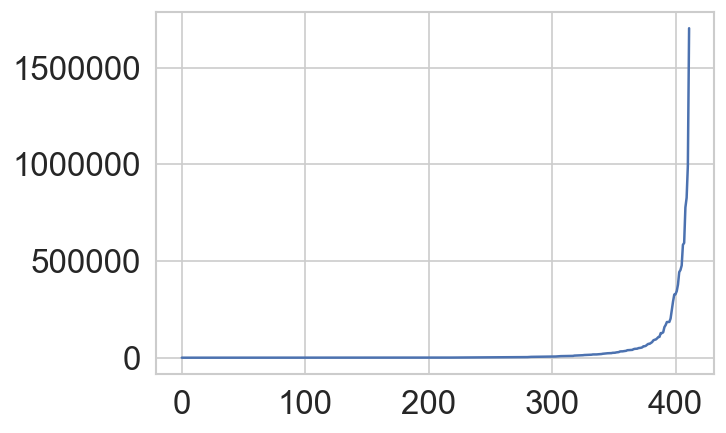

In [198]:
aa44 = pd.DataFrame(mapped_orders.groupby([0],as_index=False).count())
plt.plot(sorted(list(pd.Series(aa44[1]))))

In [199]:
activity = {}
for n in G.nodes(data=True):
    activity[n[0]] = 0
    
for r in aa44.iterrows():
    activity[r[1][0]] = r[1][1]

In [201]:
nx.set_node_attributes(G, activity, "activity")

In [48]:
aa1 = aa[aa[1] > 1000].rename(columns={5:"Time [hour]", 0:"Cells"})
aa1["Time [hour]"] = (aa1["Time [hour]"]*15/60)

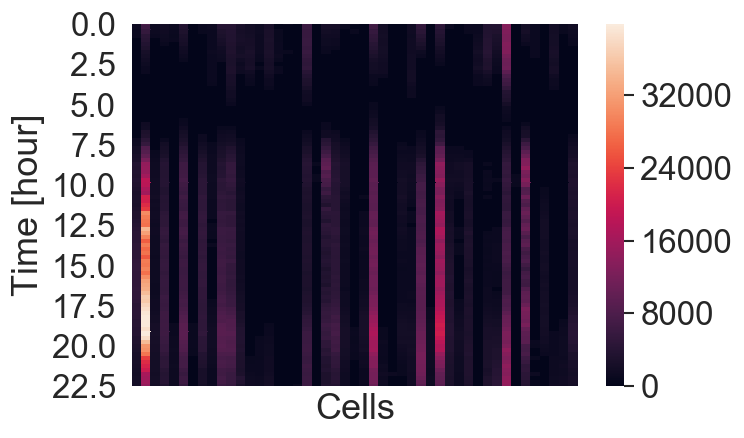

In [50]:
sns.heatmap(aa1.pivot(index="Time [hour]", columns="Cells", values=1).fillna(0))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

In [106]:
aa2 = aa[aa[1] > 9000].rename(columns={5:"Time [hour]", 0:"Cells"})
aa2["Time [hour]"] = (aa2["Time [hour]"]*15/60)
topcells = set(aa2['Cells'])

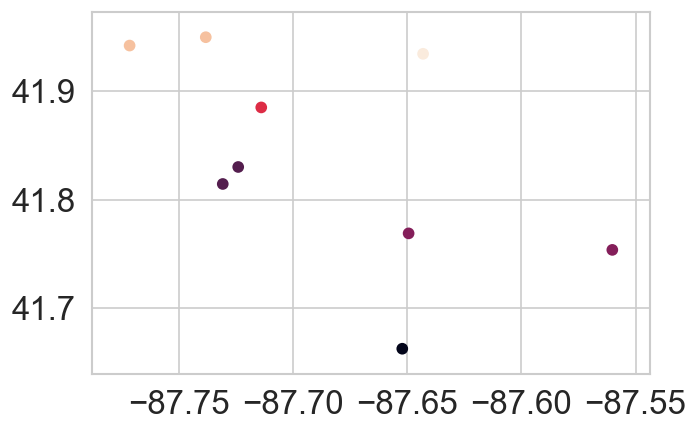

In [107]:
temp = [(n[1]['coords'][0], n[1]['coords'][1],n[1]['space_division'],n[0]) for n in G.nodes(data=True) if n[0] in topcells]
temp = np.array(temp)
plt.scatter(temp[:,0], temp[:,1],c=temp[:,2]/np.max(temp[:,2]))

In [108]:
temp

array([[-87.64935956,  41.76876653,   5.        ,  17.        ],
       [-87.72395087,  41.83006543,   4.        ,  98.        ],
       [-87.73071452,  41.81438035,   4.        , 128.        ],
       [-87.71386248,  41.88504484,   7.        , 260.        ],
       [-87.65213235,  41.66227531,   2.        , 335.        ],
       [-87.56018635,  41.75353019,   5.        , 505.        ],
       [-87.64302417,  41.9345409 ,  11.        , 532.        ],
       [-87.73815125,  41.94987713,  10.        , 650.        ],
       [-87.77149535,  41.94216899,  10.        , 696.        ]])

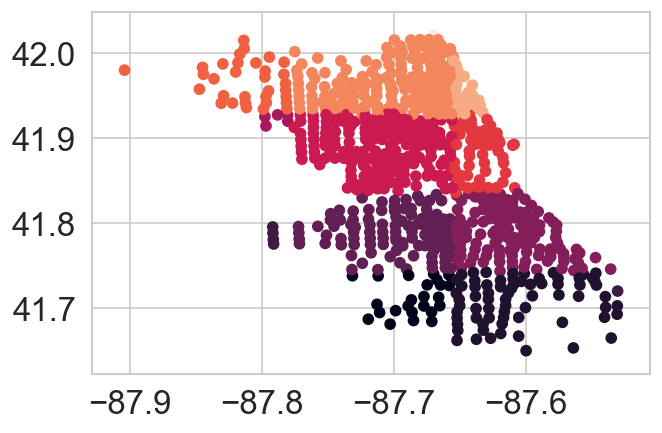

In [93]:
temp = [(n[1]['coords'][0], n[1]['coords'][1],n[1]['space_division']) for n in G.nodes(data=True)]
temp = np.array(temp)
plt.scatter(temp[:,0], temp[:,1],c=temp[:,2]/np.max(temp[:,2]))

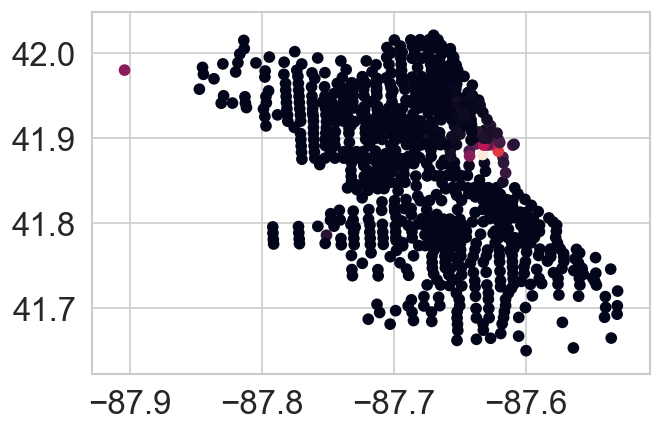

In [202]:
temp = [(n[1]['coords'][0], n[1]['coords'][1],n[1]['activity']) for n in G.nodes(data=True)]
temp = np.array(temp)
plt.scatter(temp[:,0], temp[:,1],c=temp[:,2]/np.max(temp[:,2]))

In [122]:
center_nodes = set([17, 98, 128, 260, 335, 505, 532, 650, 696])

In [123]:
voron = nx.voronoi_cells(G, center_nodes)

In [124]:
inv_voron = {}
for k, v in voron.items():
    for vv in v:
        inv_voron[vv] = k

In [125]:
nx.set_node_attributes(G, inv_voron, name="voron_division")

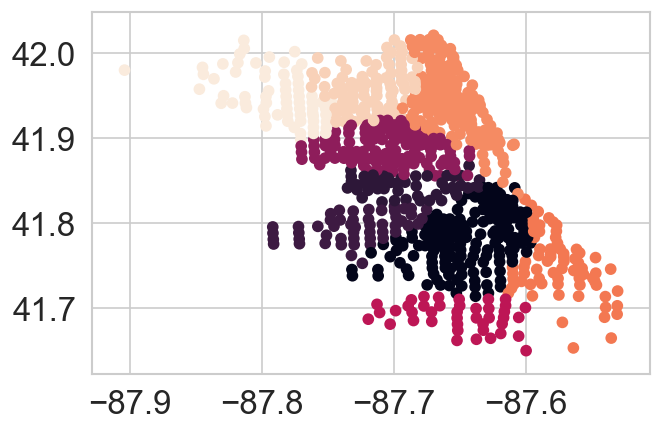

In [126]:
temp = [(n[1]['coords'][0], n[1]['coords'][1],n[1]['voron_division']) for n in G.nodes(data=True)]
temp = np.array(temp)
plt.scatter(temp[:,0], temp[:,1],c=temp[:,2]/np.max(temp[:,2]))

In [28]:
bb = pd.DataFrame(mapped_orders.groupby([5],as_index=False).count())
bb

,5,0,1,2,3,4
0,0.0,141308,141308,141308,141308,141308
1,1.0,133980,133980,133980,133980,133980
2,2.0,125042,125042,125042,125042,125042
3,3.0,117087,117087,117087,117087,117087
4,4.0,113169,113169,113169,113169,113169
...,...,...,...,...,...,...
91,91.0,171262,171262,171262,171262,171262
92,92.0,169462,169462,169462,169462,169462
93,93.0,165573,165573,165573,165573,165573
94,94.0,155943,155943,155943,155943,155943


Text(0, 0.5, 'Number of trips per year')

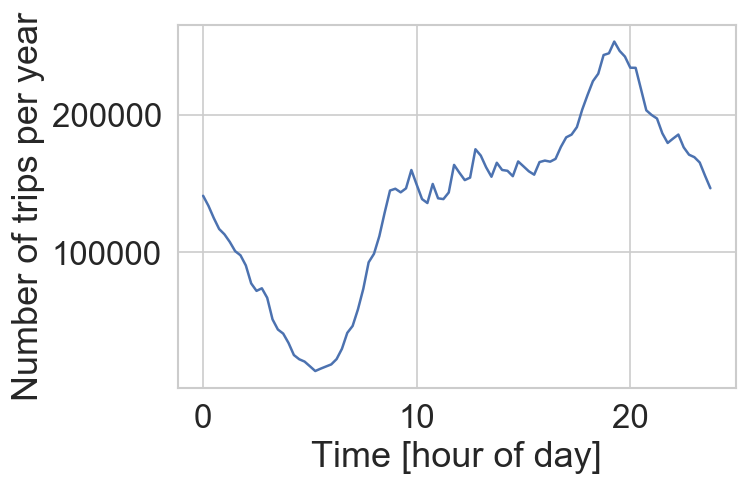

In [35]:
plt.plot(bb[5]*15/60, bb[0])
plt.xlabel("Time [hour of day]")
plt.ylabel("Number of trips per year")

In [150]:
df_filtered['distances'].describe()

count    1.317939e+07
mean     3.518963e+00
std      1.931126e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      1.400000e+01
Name: distances, dtype: float64

In [152]:
df_filtered['distances'].head()

13285001    1
13598460    2
1948228     4
2826574     3
13489876    4
Name: distances, dtype: int64

In [151]:
df_filtered['price'].describe()

count    1.317939e+07
mean     1.081853e+01
std      8.820143e+00
min      1.000000e-01
25%      5.850000e+00
50%      7.450000e+00
75%      1.085000e+01
max      4.985000e+01
Name: price, dtype: float64

# Extracting drivers

In [204]:
drivers = {}
for index, row in df_filtered.iterrows():
    if row['Trip Start Timestamp'].timestamp()-init_time > 60*60*3:
        break
    if row['Taxi ID'] not in drivers:
        drivers[row['Taxi ID']] = census_to_id[str(row['Pickup Census Tract'])]

nodes_occupancy = np.zeros(len(G))
for d in drivers:
    nodes_occupancy[drivers[d]] += 1

In [205]:
len(drivers)

1367

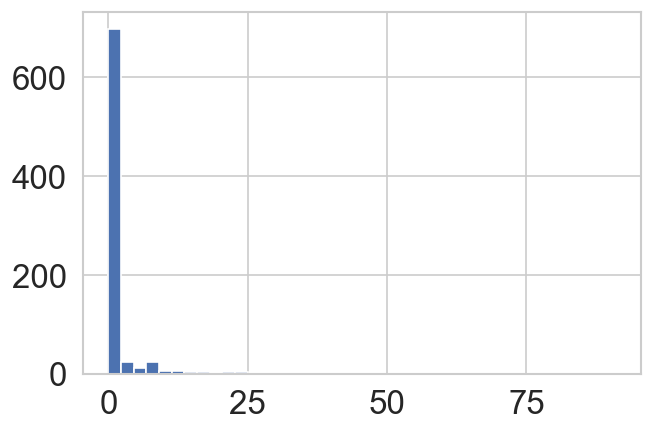

In [206]:
pd.Series(nodes_occupancy).hist(bins=40)

In [222]:
# pkl.dump(nodes_occupancy, open(os.path.join(DATA_PATH, "mapped_drivers.pkl"), "wb"))
pkl.dump(nodes_occupancy, open(os.path.join(DATA_PATH, "mapped_drivers_fixed.pkl"), "wb"))

# Get target-oriented policy

Per each census track we need to get a list of nearest hubs to aim for.

In [207]:
top_hubs_set = pkl.load(open(os.path.join(DATA_PATH, "31-top-hubs.pkl"),'rb'))
G = nx.read_gpickle(os.path.join(DATA_PATH, "chicago_g_new.pkl"))
distances = pkl.load(open(os.path.join(DATA_PATH, "distances.pkl"), "rb"))

In [208]:
G.nodes[0]

{'census': '17031842400', 'coords': (-87.63004035576937, 41.74247518248426)}

In [209]:
for n in G.nodes(data=True):
    print(n)
    break

(0, {'census': '17031842400', 'coords': (-87.63004035576937, 41.74247518248426)})


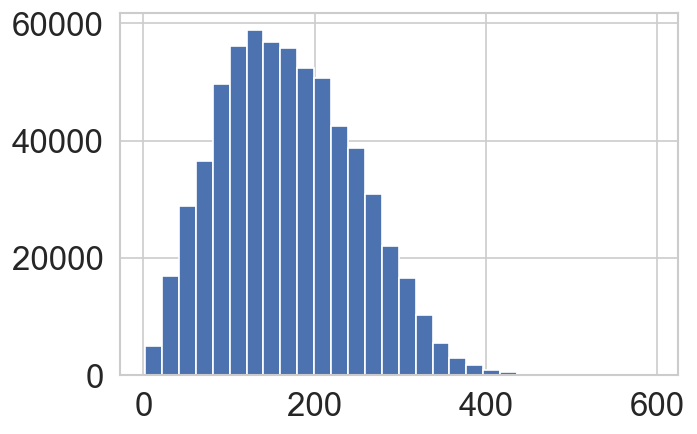

In [210]:
pd.Series([distances[k] for k in distances]).hist(bins=30)

In [211]:
census = geopandas.read_file(open(os.path.join(DATA_PATH, "Boundaries - Census Tracts - 2010.geojson"), "r").read()) 
census_geoids = set([i for i in census['geoid10'].unique() if i not in ['17031770602', '17031510100']])
census_to_id_int = {int(k) : v for k, v in census_to_id.items()}
census_to_name10_int = {k : census[census['geoid10'] == G.nodes[v]['census']].iloc[0]['name10'] for k, v in census_to_id_int.items()}
census_to_name10_int_inv = {v: k for k, v in census_to_name10_int.items()}

In [212]:
distances_name10 = {}
for k in distances:
    try:
        distances_name10[(str(census_to_name10_int_inv[k[0]]), str(census_to_name10_int_inv[k[1]]))] = distances[k]
    except Exception:
        pass # some censuses are not present

In [213]:
census_to_nodes = {}
for n in G.nodes(data=True):
    census_to_nodes[n[1]['census']] = n[0]

In [214]:
len(list(nx.connected_components(G)))

1

In [215]:
actions = {}
for n in G.nodes(data=True):
    
    assert census_to_nodes[n[1]['census']] == n[0]
    dist_to_hubs = []
    for nn in top_hubs_set:
        path = nx.shortest_path(G, census_to_nodes[n[1]['census']], census_to_nodes[str(nn)])
        dist = nx.shortest_path_length(G, census_to_nodes[n[1]['census']], census_to_nodes[str(nn)])
        assert path[0] == census_to_nodes[n[1]['census']]
        assert G.nodes[path[0]]['census'] == n[1]['census']
        dist_to_hubs.append((dist, str(nn), path))
    dist_to_hubs.sort()
    top_hubs = [(t[1], t[2]) for t in dist_to_hubs if t[0] == dist_to_hubs[0][0]]
    if int(n[1]['census']) in top_hubs_set:
        top_hubs.append((n[1]['census'], []))
    
    # now we need to get the first nearest jump towards the hubs with ties
    next_cells = []
    
    neigh_census = set([G.nodes[nn]['census'] for nn in G.neighbors(n[0])])
    
    for top_hub, path in top_hubs:
        if top_hub == n[1]['census']:
                next_cells.append(top_hub)
                continue
        next_cell = G.nodes[path[1]]['census']
        assert(next_cell in neigh_census)
        assert G.nodes[path[0]]['census'] == n[1]['census'], (G.nodes[path[0]]['census'], n[1]['census'])
        assert G.nodes[path[1]]['census'] != n[1]['census']
        next_cells.append(next_cell)
    
    next_cells_dict = {}
    if len(next_cells) > 0:
        part = 1./len(next_cells)
        for cell in next_cells:
            if cell in next_cells_dict:
                next_cells_dict[cell] += part
            else:
                next_cells_dict[cell] = part
    assert n[1]['census'] not in actions
    actions[n[1]['census']] = next_cells_dict
    
print(actions['17031841900'])

{'17031841900': 1.0}


In [216]:
# pkl.dump(actions, open(os.path.join(DATA_PATH, "to_hub_actions.pkl"),'wb'))
pkl.dump(actions, open(os.path.join(DATA_PATH, "to_hub_actions_fixed.pkl"),'wb'))

In [217]:
len(actions)

799

In [218]:
G.nodes[169]

{'census': '17031839000', 'coords': (-87.63140452575338, 41.871044193578264)}

In [219]:
actions['17031839000']

{'17031839000': 1.0}